In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_dir = "../dataset/train_test_data/train"
test_dir = "../dataset/train_test_data/test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
num_epochs = 15
lr = 1e-4


In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

num_classes = len(train_dataset.classes)
print(f"Classes found: {train_dataset.classes}")




Classes found: ['Irrelavent', 'Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


# MODEL  (EfficientNet-B3 + Swin Transformer)

In [4]:
# =========================================================
# MODEL DEFINITION (EfficientNet-B3 + Swin Transformer)
# =========================================================
from torchvision.models import efficientnet_b3, swin_t, EfficientNet_B3_Weights, Swin_T_Weights

class EffSwinB3(nn.Module):
    def __init__(self, num_classes):
        super(EffSwinB3, self).__init__()
        self.eff = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.swin = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)
        
        # Remove final classification heads
        self.eff.classifier = nn.Identity()
        self.swin.head = nn.Identity()

        eff_feat_dim = 1536  # EfficientNet-B3 output features
        swin_feat_dim = 768  # Swin-T output features

        self.fc = nn.Sequential(
            nn.Linear(eff_feat_dim + swin_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        eff_features = self.eff(x)
        swin_features = self.swin(x)
        combined = torch.cat((eff_features, swin_features), dim=1)
        out = self.fc(combined)
        return out


model = EffSwinB3(num_classes=num_classes).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 192MB/s]
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 189MB/s] 


In [5]:
# =========================================================
# TRAINING SETUP
# =========================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# =========================================================
# TRAINING LOOP
# =========================================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_running_loss / len(test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch [1/15] Train Loss: 0.5299 | Train Acc: 76.26% | Val Loss: 1.7165 | Val Acc: 82.80%
Epoch [2/15] Train Loss: 0.3347 | Train Acc: 85.16% | Val Loss: 0.2516 | Val Acc: 88.91%
Epoch [3/15] Train Loss: 0.2648 | Train Acc: 88.98% | Val Loss: 1.2990 | Val Acc: 89.69%
Epoch [4/15] Train Loss: 0.1996 | Train Acc: 92.02% | Val Loss: 2.2971 | Val Acc: 94.55%
Epoch [5/15] Train Loss: 0.1447 | Train Acc: 94.34% | Val Loss: 0.1323 | Val Acc: 95.14%
Epoch [6/15] Train Loss: 0.0899 | Train Acc: 96.79% | Val Loss: 0.6458 | Val Acc: 97.53%
Epoch [7/15] Train Loss: 0.0610 | Train Acc: 97.84% | Val Loss: 1.1590 | Val Acc: 97.69%
Epoch [8/15] Train Loss: 0.0567 | Train Acc: 97.97% | Val Loss: 0.1326 | Val Acc: 97.96%
Epoch [9/15] Train Loss: 0.0484 | Train Acc: 98.28% | Val Loss: 0.3164 | Val Acc: 97.69%
Epoch [10/15] Train Loss: 0.0400 | Train Acc: 98.45% | Val Loss: 0.7903 | Val Acc: 98.90%
Epoch [11/15] Train Loss: 0.0267 | Train Acc: 99.06% | Val Loss: 0.2858 | Val Acc: 99.02%
Epoch [12/15] Train


Classification Report:
                      precision    recall  f1-score   support

          Irrelavent       1.00      1.00      1.00       503
     Mild Impairment       1.00      0.99      1.00       512
 Moderate Impairment       1.00      1.00      1.00       512
       No Impairment       0.99      0.96      0.98       512
Very Mild Impairment       0.96      0.99      0.98       513

            accuracy                           0.99      2552
           macro avg       0.99      0.99      0.99      2552
        weighted avg       0.99      0.99      0.99      2552



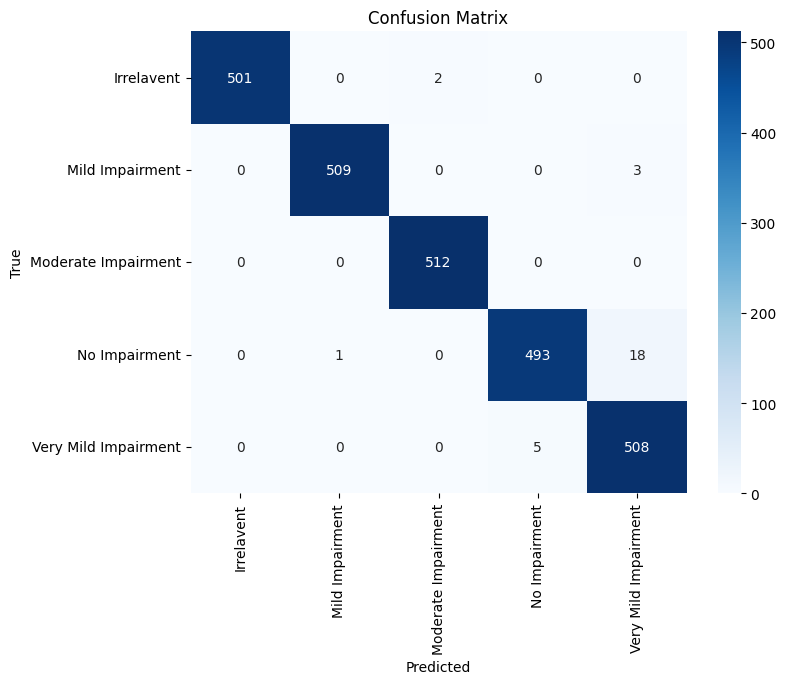

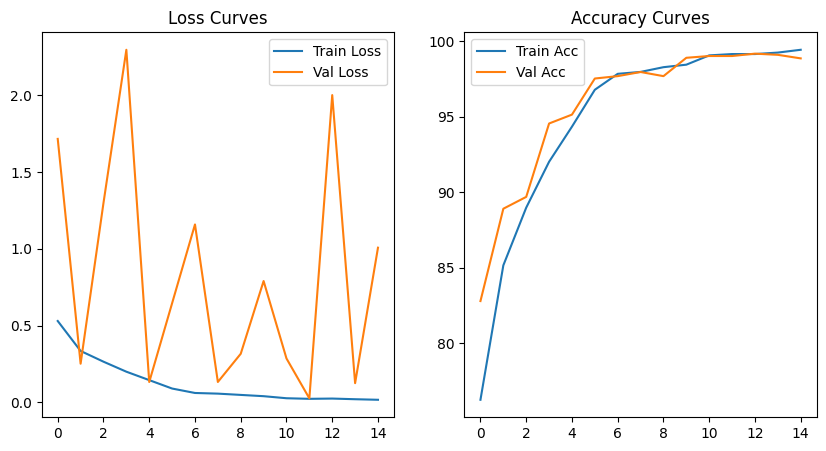

 Model saved as EffSwin_B3_model.pth


In [7]:
# =========================================================
# EVALUATION
# =========================================================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =========================================================
# PLOT TRAINING CURVES
# =========================================================
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy Curves")
plt.show()

# =========================================================
# SAVE MODEL
# =========================================================
torch.save(model.state_dict(), "EffSwin_B3_model.pth")
print(" Model saved as EffSwin_B3_model.pth")

 # MODEL (ResNet-50 + Swin Transformer)

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# CONFIGURATION
# =========================================================
train_dir = "/kaggle/input/alzheimersdataset/train_test_data/train"
test_dir = "/kaggle/input/alzheimersdataset/train_test_data/test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
num_epochs = 30
lr = 1e-4
patience = 5  # early stopping patience

# =========================================================
# DATA PREPARATION
# =========================================================
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Classes found: {train_dataset.classes}")

Classes found: ['Irrelavent', 'Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 220MB/s] 


Epoch [1/10] Train Loss: 0.5098 | Train Acc: 77.79% | Val Loss: 0.3538 | Val Acc: 84.33%
Epoch [2/10] Train Loss: 0.2971 | Train Acc: 87.48% | Val Loss: 0.3077 | Val Acc: 87.70%
Epoch [3/10] Train Loss: 0.2348 | Train Acc: 90.51% | Val Loss: 0.2251 | Val Acc: 90.48%
Epoch [4/10] Train Loss: 0.1705 | Train Acc: 93.60% | Val Loss: 0.2028 | Val Acc: 92.24%
Epoch [5/10] Train Loss: 0.1312 | Train Acc: 95.05% | Val Loss: 0.0823 | Val Acc: 96.94%
Epoch [6/10] Train Loss: 0.0604 | Train Acc: 97.85% | Val Loss: 0.0750 | Val Acc: 96.98%
Epoch [7/10] Train Loss: 0.0451 | Train Acc: 98.40% | Val Loss: 0.0732 | Val Acc: 97.18%
Epoch [8/10] Train Loss: 0.0368 | Train Acc: 98.68% | Val Loss: 0.0565 | Val Acc: 98.16%
Epoch [9/10] Train Loss: 0.0334 | Train Acc: 98.74% | Val Loss: 0.0427 | Val Acc: 98.32%
Epoch [10/10] Train Loss: 0.0268 | Train Acc: 99.09% | Val Loss: 0.0563 | Val Acc: 98.35%

Classification Report:
                      precision    recall  f1-score   support

          Irrelavent  

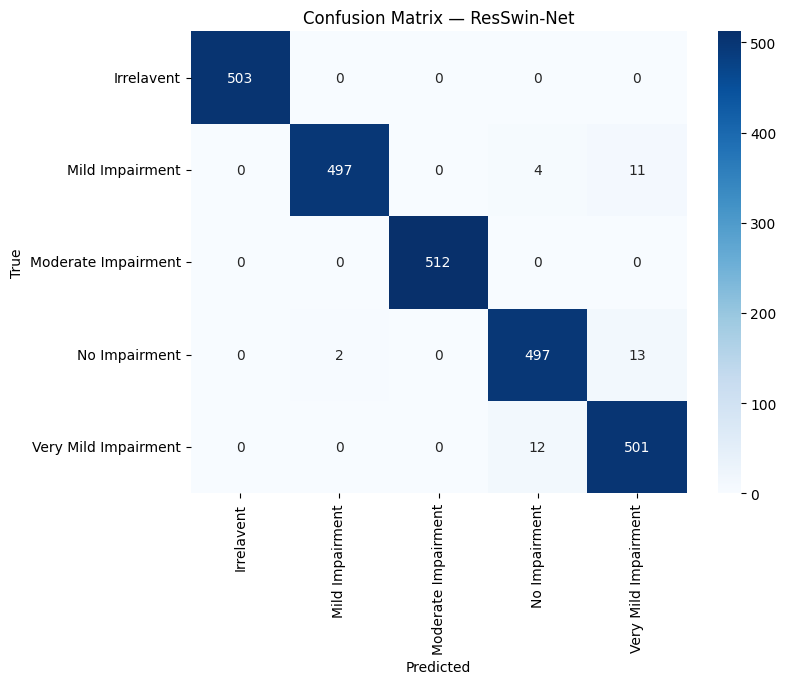

Model saved as ResSwin_final.pth


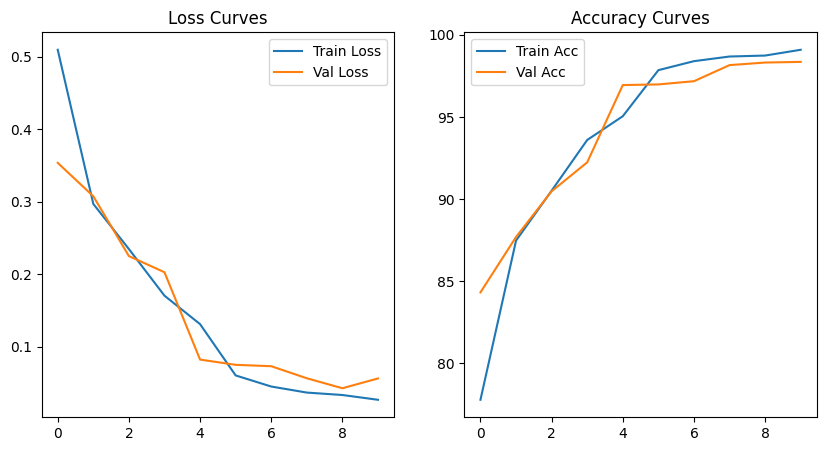

In [2]:
# =========================================================
# MODEL DEFINITION (ResNet-50 + Swin Transformer)
# =========================================================
from torchvision.models import resnet50, swin_t, ResNet50_Weights, Swin_T_Weights
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class ResSwinNet(nn.Module):
    def __init__(self, num_classes):
        super(ResSwinNet, self).__init__()
        # Load pre-trained backbones
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.swin = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

        # Remove classification heads
        self.resnet.fc = nn.Identity()
        self.swin.head = nn.Identity()

        res_dim = 2048
        swin_dim = 768

        # Fusion + classification
        self.fc = nn.Sequential(
            nn.Linear(res_dim + swin_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        res_feat = self.resnet(x)
        swin_feat = self.swin(x)
        combined = torch.cat((res_feat, swin_feat), dim=1)
        return self.fc(combined)

# Initialize model
model = ResSwinNet(num_classes=num_classes).to(device)

# =========================================================
# TRAINING SETUP
# =========================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# =========================================================
# TRAINING LOOP (10 EPOCHS)
# =========================================================
num_epochs = 10  # fixed 10 epochs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# =========================================================
# EVALUATION
# =========================================================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix — ResSwin-Net")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =========================================================
# SAVE FINAL MODEL
# =========================================================
torch.save(model.state_dict(), "ResSwin_final.pth")
print("Model saved as ResSwin_final.pth")

# =========================================================
# PLOT TRAINING CURVES
# =========================================================
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy Curves")
plt.show()

# MODEL: DenseNet-121 + Transformer Encoder

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# CONFIGURATION
# =========================================================
train_dir = "/kaggle/input/alzheimersdataset/train_test_data/train"
test_dir = "/kaggle/input/alzheimersdataset/train_test_data/test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 16
num_epochs = 30
lr = 1e-4
patience = 5

# =========================================================
# DATA TRANSFORMS
# =========================================================
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Classes found: {train_dataset.classes}")

Classes found: ['Irrelavent', 'Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 211MB/s]


Epoch [1/30] Train Loss: 0.4827 | Train Acc: 79.36% | Val Loss: 0.3900 | Val Acc: 83.50%
Validation loss improved — model saved to DenseTrans_best.pth
Epoch [2/30] Train Loss: 0.3404 | Train Acc: 85.51% | Val Loss: 0.3673 | Val Acc: 83.42%
Validation loss improved — model saved to DenseTrans_best.pth
Epoch [3/30] Train Loss: 0.2876 | Train Acc: 88.09% | Val Loss: 0.2192 | Val Acc: 91.03%
Validation loss improved — model saved to DenseTrans_best.pth
Epoch [4/30] Train Loss: 0.2433 | Train Acc: 90.32% | Val Loss: 0.1963 | Val Acc: 92.12%
Validation loss improved — model saved to DenseTrans_best.pth
Epoch [5/30] Train Loss: 0.2074 | Train Acc: 91.66% | Val Loss: 0.1726 | Val Acc: 92.91%
Validation loss improved — model saved to DenseTrans_best.pth
Epoch [6/30] Train Loss: 0.1188 | Train Acc: 95.28% | Val Loss: 0.1236 | Val Acc: 95.49%
Validation loss improved — model saved to DenseTrans_best.pth
Epoch [7/30] Train Loss: 0.0967 | Train Acc: 96.43% | Val Loss: 0.0999 | Val Acc: 96.67%
Valid

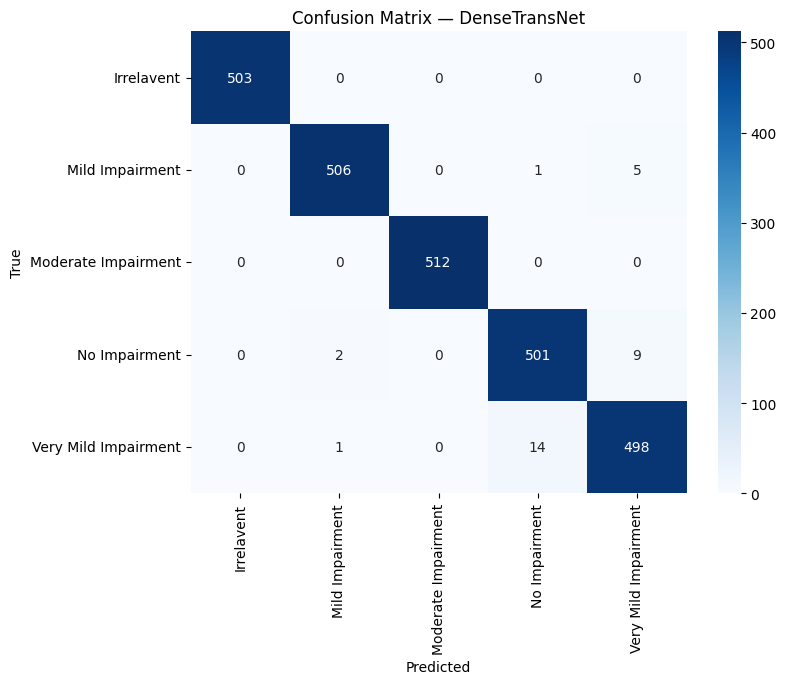

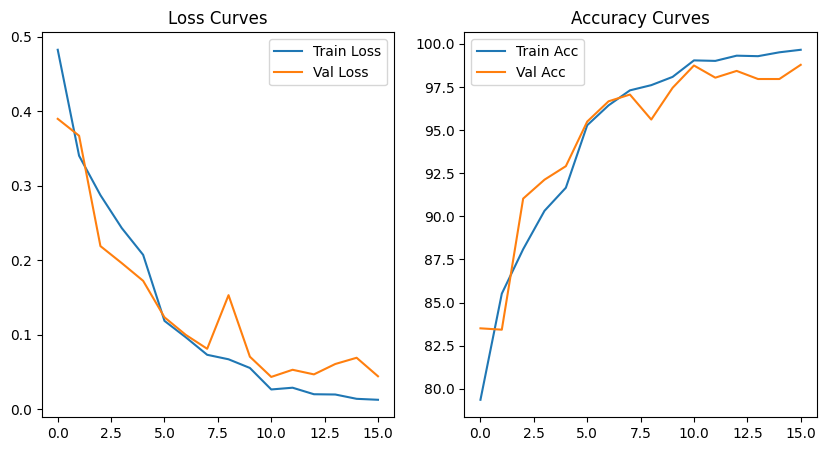

 Model saved as DenseTrans_final.pth


In [9]:
# =========================================================
# MODEL: DenseNet-121 + Transformer Encoder
# =========================================================
from torchvision.models import densenet121, DenseNet121_Weights

class DenseTransNet(nn.Module):
    def __init__(self, num_classes, num_heads=8, num_layers=2, hidden_dim=512):
        super(DenseTransNet, self).__init__()

        # DenseNet feature extractor
        self.densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        self.densenet.classifier = nn.Identity()  # remove final classifier

        self.feature_dim = 1024  # DenseNet-121 output features

        # Project CNN features for Transformer
        self.projection = nn.Linear(self.feature_dim, hidden_dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.3,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # CNN feature extraction
        feats = self.densenet.features(x)  # (B, 1024, 7, 7)
        feats = nn.functional.adaptive_avg_pool2d(feats, (7, 7))  # ensure 7x7 spatial map
        B, C, H, W = feats.shape
        feats = feats.view(B, C, H * W).permute(0, 2, 1)  # (B, 49, 1024)

        # Project features
        proj_feats = self.projection(feats)  # (B, 49, hidden_dim)

        # Transformer Encoder
        trans_out = self.transformer(proj_feats)  # (B, 49, hidden_dim)

        # Global average pooling across sequence
        out = trans_out.mean(dim=1)

        # Classification
        return self.fc(out)


model = DenseTransNet(num_classes=num_classes).to(device)

# =========================================================
# TRAINING SETUP
# =========================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



# =========================================================
# EARLY STOPPING
# =========================================================
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f"Validation loss improved — model saved to {self.path}")

early_stopper = EarlyStopping(patience=patience, verbose=True, path='DenseTrans_best.pth')

# =========================================================
# TRAINING LOOP
# =========================================================
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print(" Early stopping triggered!")
        break

# =========================================================
# LOAD BEST MODEL
# =========================================================
model.load_state_dict(torch.load('DenseTrans_best.pth'))

# =========================================================
# EVALUATION
# =========================================================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix — DenseTransNet")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =========================================================
# PLOT TRAINING CURVES
# =========================================================
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy Curves")
plt.show()

# =========================================================
# SAVE FINAL MODEL
# =========================================================
torch.save(model.state_dict(), "DenseTrans_final.pth")
print(" Model saved as DenseTrans_final.pth")

In [1]:
# ============================================================
# Independent evaluation cell for ResSwin, DenseTrans, EffSwin
# ============================================================

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import (
    resnet50, swin_t, ResNet50_Weights, Swin_T_Weights,
    densenet121, DenseNet121_Weights,
    efficientnet_b3, EfficientNet_B3_Weights
)
from torch.utils.data import DataLoader

# ---------- DEVICE ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- TEST DATA PATH ----------
TEST_DIR = r"C:\Users\bhumi\Desktop\Alzh Project\dataset\train_test_data\test"

# ---------- DATA LOADER ----------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
num_classes = len(test_dataset.classes)

# ============================================================
# MODEL DEFINITIONS
# ============================================================

# 1. ResNet-50 + Swin Transformer
class ResSwinNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.swin = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

        self.resnet.fc = nn.Identity()
        self.swin.head = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.fc(torch.cat((self.resnet(x), self.swin(x)), dim=1))


# 2. DenseNet-121 + Transformer Encoder (DenseTrans)
class DenseTransNet(nn.Module):
    def __init__(self, num_classes, num_heads=8, num_layers=2, hidden_dim=512):
        super().__init__()

        self.densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        self.densenet.classifier = nn.Identity()

        self.projection = nn.Linear(1024, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.3,
            activation="gelu",
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        feats = self.densenet.features(x)
        feats = nn.functional.adaptive_avg_pool2d(feats, (7, 7))
        B, C, H, W = feats.shape
        feats = feats.view(B, C, H * W).permute(0, 2, 1)

        feats = self.projection(feats)
        feats = self.transformer(feats)
        feats = feats.mean(dim=1)

        return self.fc(feats)


# 3. EfficientNet-B3 + Swin Transformer (EffSwin)
class EffSwinB3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.eff = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.swin = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

        self.eff.classifier = nn.Identity()
        self.swin.head = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(1536 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        eff_feat = self.eff(x)
        swin_feat = self.swin(x)
        return self.fc(torch.cat((eff_feat, swin_feat), dim=1))


# ============================================================
# ACCURACY FUNCTION
# ============================================================
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return round(100 * correct / total, 2)


# ============================================================
# MODEL PATHS
# ============================================================
MODEL_PATHS = {
    "ResNet + Swin": "results/ResSwin_best.pth",
    "DenseNet + Transformer": "results/DenseTrans_best.pth",
    "EfficientNet + Swin": "results/EffSwin_B3_model.pth"
}
from sklearn.metrics import precision_recall_fscore_support

def evaluate_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )

    weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )

    return {
        "Macro": (round(macro_p, 4), round(macro_r, 4), round(macro_f1, 4)),
        "Weighted": (round(weighted_p, 4), round(weighted_r, 4), round(weighted_f1, 4))
    }

# ============================================================
# LOAD MODELS & PRINT ACCURACY
# ============================================================
print("TEST ACCURACY RESULTS")
print("=====================")

res_model = ResSwinNet(num_classes).to(device)
res_model.load_state_dict(torch.load(MODEL_PATHS["ResNet + Swin"], map_location=device))
print(f"ResNet + Swin          : {evaluate(res_model, test_loader)}%")

dense_model = DenseTransNet(num_classes).to(device)
dense_model.load_state_dict(torch.load(MODEL_PATHS["DenseNet + Transformer"], map_location=device))
print(f"DenseNet + Transformer : {evaluate(dense_model, test_loader)}%")

eff_model = EffSwinB3(num_classes).to(device)
eff_model.load_state_dict(torch.load(MODEL_PATHS["EfficientNet + Swin"], map_location=device))
print(f"EfficientNet + Swin    : {evaluate(eff_model, test_loader)}%")

print("\nDETAILED TEST METRICS")
print("====================")

res_metrics = evaluate_metrics(res_model, test_loader)
print("ResNet + Swin")
print("Macro     (P, R, F1):", res_metrics["Macro"])
print("Weighted  (P, R, F1):", res_metrics["Weighted"])
print()

dense_metrics = evaluate_metrics(dense_model, test_loader)
print("DenseNet + Transformer")
print("Macro     (P, R, F1):", dense_metrics["Macro"])
print("Weighted  (P, R, F1):", dense_metrics["Weighted"])
print()

eff_metrics = evaluate_metrics(eff_model, test_loader)
print("EfficientNet + Swin")
print("Macro     (P, R, F1):", eff_metrics["Macro"])
print("Weighted  (P, R, F1):", eff_metrics["Weighted"])



TEST ACCURACY RESULTS
ResNet + Swin          : 99.22%
DenseNet + Transformer : 98.75%
EfficientNet + Swin    : 98.86%

DETAILED TEST METRICS
ResNet + Swin
Macro     (P, R, F1): (0.9922, 0.9922, 0.9922)
Weighted  (P, R, F1): (0.9922, 0.9922, 0.9922)

DenseNet + Transformer
Macro     (P, R, F1): (0.9875, 0.9875, 0.9875)
Weighted  (P, R, F1): (0.9875, 0.9875, 0.9875)

EfficientNet + Swin
Macro     (P, R, F1): (0.9889, 0.9887, 0.9887)
Weighted  (P, R, F1): (0.9888, 0.9886, 0.9886)


In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet50, swin_t, ResNet50_Weights, Swin_T_Weights
from PIL import Image
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CLASS_NAMES = [
    "Irrelevant",
    "Mild Impairment",
    "Moderate Impairment",
    "No Impairment",
    "Very Mild Impairment"
]

class ResSwinNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.swin = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

        self.resnet.fc = nn.Identity()
        self.swin.head = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.fc(torch.cat((self.resnet(x), self.swin(x)), dim=1))


MODEL_PATH = r"results/ResSwin_best.pth"   # change if needed

model = ResSwinNet(num_classes=len(CLASS_NAMES)).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


image_paths = [
    r"C:\Users\bhumi\Desktop\Alzh Project\dataset\train_test_data\test\Irrelavent\3.jpg",
    r"C:\Users\bhumi\Desktop\Alzh Project\dataset\train_test_data\test\Mild Impairment\MildImpairment (1020).jpg",
    r"C:\Users\bhumi\Desktop\Alzh Project\dataset\train_test_data\test\Moderate Impairment\ModerateImpairment (1037).jpg",
    r"C:\Users\bhumi\Desktop\Alzh Project\dataset\train_test_data\test\No Impairment\NoImpairment (1041).jpg",
    r"C:\Users\bhumi\Desktop\Alzh Project\dataset\train_test_data\test\Very Mild Impairment\VeryMildImpairment (1023).jpg"
]


print("RESNET+SWIN(BEST MODEL) RESULTS")
print("==========================")

for img_path in image_paths:
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1)
        confidence, pred_idx = torch.max(probs, dim=1)

    predicted_class = CLASS_NAMES[pred_idx.item()]
    confidence = round(confidence.item() * 100, 2)

    print(f"\nImage : {os.path.basename(img_path)}")
    print(f"Predicted Class : {predicted_class}")
    print(f"Confidence      : {confidence}%")


RESNET+SWIN(BEST MODEL) RESULTS

Image : 3.jpg
Predicted Class : Irrelevant
Confidence      : 100.0%

Image : MildImpairment (1020).jpg
Predicted Class : Mild Impairment
Confidence      : 100.0%

Image : ModerateImpairment (1037).jpg
Predicted Class : Moderate Impairment
Confidence      : 100.0%

Image : NoImpairment (1041).jpg
Predicted Class : No Impairment
Confidence      : 100.0%

Image : VeryMildImpairment (1023).jpg
Predicted Class : Very Mild Impairment
Confidence      : 99.75%
